In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
vzrenggamani/hanacaraka                                     Aksara Jawa / Hanacaraka                           9MB  2020-07-10 15:09:31             71  
vishnuvarthanrao/windows-store                              Windows Store                                     93KB  2020-07-07 12:29:07           1111  
mrgeislinger/bart-ridership                                 BART Ridership                                   325MB  2020-07-09 22:28:07            198  
rohanrao/chai-time-data-science                             Chai Time Data Science | CTDS.Show                 3MB  2020-07-23 17:23:46            727  
garystafford/environmental-sensor-data-132k                 Environmental Sensor T

In [ ]:
# !kaggle competitions download -c house-prices-advanced-regression-techniques
!kaggle competitions download -c shopee-sentiment-analysis
!ls

  0% 0.00/63.0 [00:00<?, ?B/s]
100% 63.0/63.0 [00:00<00:00, 129kB/s]
  0% 0.00/2.22M [00:00<?, ?B/s]
100% 2.22M/2.22M [00:00<00:00, 73.6MB/s]
100% 4.78M/4.78M [00:01<00:00, 4.88MB/s]

kaggle.json  sample_data  sampleSubmission.csv	test.csv.zip  train.csv.zip


In [ ]:
# import specific libraries
# load CSVs
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
sample_sub = pd.read_csv('sampleSubmission.csv')

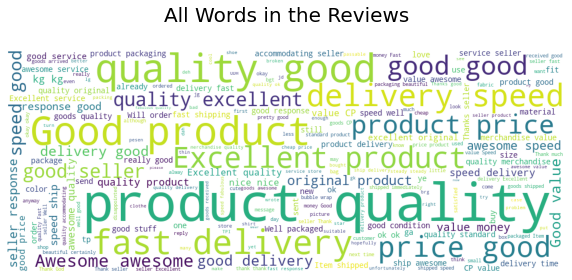

In [ ]:
#@title wordcloud
rt = train['review']
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=20)
plt.axis('off')
plt.show()

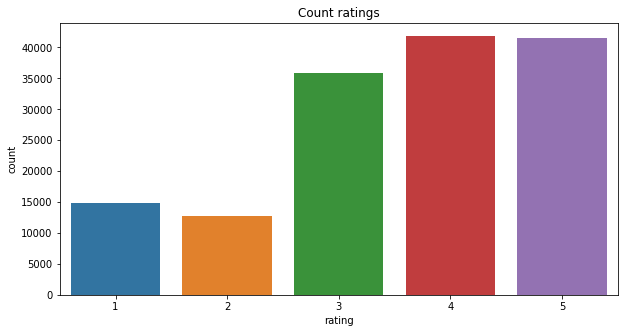

In [ ]:
#@title count
plt.figure(figsize=(10,5))
sns.countplot(train['rating'])
plt.title('Count ratings')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#lower case all text
train["review"]=train["review"].str.lower() 
test["review"]=test["review"].str.lower() 
#tokenization of words
train["review"] = train.apply(lambda row: word_tokenize(row['review']), axis=1) 
test["review"] = test.apply(lambda row: word_tokenize(row['review']), axis=1) 
#only alphanumerical values
train["review"] = train["review"].apply(lambda x: [item for item in x if item.isalpha()]) 
test["review"] = test["review"].apply(lambda x: [item for item in x if item.isalpha()]) 
#lemmatazing words
train["review"] = train["review"].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
test["review"] = test["review"].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
#removing useless words
stop = stopwords.words('english')
train["review"] = train["review"].apply(lambda x: [item for item in x if item not in stop])
test["review"] = test["review"].apply(lambda x: [item for item in x if item not in stop])

In [ ]:
train["review"] = train["review"].apply(lambda x: str(' '.join(x))) #joining all tokens
test["review"] = test["review"].apply(lambda x: str(' '.join(x))) #joining all tokens

In [ ]:
import pandas as pd
import numpy as np
import json

#Loading additional helper functions not shown here but provided in the folder
%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

ERROR:root:File `'nlp_utils_news.ipynb.py'` not found.


In [ ]:
texts = train.review.astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = train.rating.values #target

print (X.shape)
print(y.shape)

(146811, 105630)
(146811,)


In [ ]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(146811, 100)

In [ ]:
test_texts = test.review.astype('str')

X_test = tfidf_vectorizer.fit_transform(test_texts) #features

X_test = lsa.fit_transform(X_test)
X_test.shape

(60427, 100)

In [ ]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
# model_dict = {'Dummy' : DummyClassifier(random_state=3),
#               'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
#               'Random Forest': RandomForestClassifier(random_state=3),
#               'Decsision Tree': DecisionTreeClassifier(random_state=3),
#               'AdaBoost': AdaBoostClassifier(random_state=3),
#               'Gaussian Naive Bayes': GaussianNB(),
#               'K Nearest Neighbor': KNeighborsClassifier()}


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Random Forest,0.437721,0.461567,0.416958,0.425604
0,Dummy,0.239442,0.200753,0.200731,0.200736


In [ ]:
# RandomForestClassifier
v = RandomForestClassifier(random_state=3)
v.fit(X, y)
y_pred = v.predict(X_test)
y_pred

array([4, 3, 5, ..., 4, 3, 3])

In [ ]:
a = AdaBoostClassifier(random_state=3)
a.fit(X, y)
y_pred = a.predict(X_test)
y_pred

array([5, 4, 5, ..., 4, 1, 5])

In [ ]:
s = SGDClassifier(random_state=3, loss='log')
s.fit(X, y)
y_pred = s.predict(X_test)
y_pred

array([4, 3, 3, ..., 5, 3, 3])

In [ ]:
m = GaussianNB()
m.fit(X, y)
y_pred = m.predict(X_test)
y_pred

array([1, 4, 4, ..., 4, 4, 1])

In [ ]:
forsub = pd.DataFrame(test.review_id)
forsub['rating'] = list(y_pred)
forsub

,review_id,rating
0,1,1
1,2,4
2,3,4
3,4,1
4,5,1
...,...,...
60422,60423,2
60423,60424,1
60424,60425,4
60425,60426,4


In [ ]:
forsub.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c shopee-sentiment-analysis -f submission.csv -m "Message"

100% 461k/461k [00:00<00:00, 578kB/s]
Successfully submitted to [Open] Shopee Code League - Sentiment Analysis 

In [ ]:
sample_sub

,review_id,rating
0,0,4
1,1,3
2,2,5
3,3,1
4,4,2
5,5,5
6,6,5
7,7,2
8,8,3
